# Import libraries

In [1]:
import numpy as np
import numpy.ma as ma
import xarray as xr
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import gaussian_kde
import tensorflow
import io
import os
from PIL import Image
import seaborn as sns
import richdem as rd

import tensorflow as tf
import tensorflow.math
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import *
from tensorflow.keras.utils import to_categorical
# import shap

import xgboost as xgb
from xgboost import XGBRegressor
from pysr import PySRRegressor
import random

plt.rcParams['figure.figsize'] = (12,12)

2023-08-30 17:46:04.756896: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load MAR output

#### Load local MAR output for 2020 on 6.5km

In [2]:
# url = 'gs://leap-persistent/raf-antwerpen/MARv3.12-6_5km-daily-ERA5-2020.zarr'
# ds2020 = xr.open_dataset(url, engine='zarr', chunks={})
ds2020 = xr.open_dataset('/Users/raf/Documents/Columbia/Research/Albedo/Data/MAR/MARv3.12-6_5km-daily-ERA5-2020.nc')

In [3]:
jun1 = 151
aug31 = 242
numberdays = aug31-jun1+1
jun1_leap = jun1 + 1
aug31_leap = aug31 + 1

numberyears = 22
numberdaystot = numberyears * numberdays
n_feature = 20
n_lat = 415
n_lon = 230

In [4]:
LAT = ds2020.LAT.values
LON = ds2020.LON.values
AL2_2020 = ds2020.AL2.values[jun1:aug31+1,0,:n_lat,:n_lon]

In [5]:
SH_vals = rd.rdarray(ds2020.SH.values, no_data=-9999)

slope = rd.TerrainAttribute(SH_vals, attrib='slope_riserun')
aspect = rd.TerrainAttribute(SH_vals, attrib='aspect')

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)



A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.00481496===================== ] (99% - 0.0s - 1 threads)

A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.00863394===================== ] (99% - 0.0s - 1 threads)           ] (19% - 0.0s - 1 threads)


In [6]:
alg2016 = np.flipud(np.array(Image.open('/Users/raf/Documents/Columbia/Research/Albedo/Data/Algae/algae2016_MARproj_6_5km.tif')))
alg2017 = np.flipud(np.array(Image.open('/Users/raf/Documents/Columbia/Research/Albedo/Data/Algae/algae2017_MARproj_6_5km.tif')))
alg2016 = np.where(alg2016 == 0, np.nan, alg2016)
alg2017 = np.where(alg2017 == 0, np.nan, alg2017)

algnan = np.zeros((415,230))
algnan = np.where(algnan == 0, np.nan, np.nan)

In [ ]:
#####################################
#####################################
### I used this setup for x_27
#####################################
#####################################

# x = np.zeros((numberyears, numberdays, n_lat, n_lon, n_feature))

# for i in range(22):
   
#     year = i + 2000
#     url = f"gs://leap-persistent/raf-antwerpen/MARv3.12-6_5km-daily-ERA5-{year}.zarr"
#     ds = xr.open_dataset(url, engine='zarr', chunks={})
    
#     # x[i,:,:,:,0] = ds.ST2.values[jun1:aug31+1,0,:n_lat,:n_lon]
#     # x[i,:,:,:,1] = ds.RU.values[jun1:aug31+1,0,:n_lat,:n_lon]
#     # x[i,:,:,:,2] = ds.ME.values[jun1:aug31+1,0,:n_lat,:n_lon]
#     # x[i,:,:,:,3] = ds.SWU.values[jun1:aug31+1,:n_lat,:n_lon]
#     x[i,:,:,:,4] = ds.SWD.values[jun1:aug31+1,:n_lat,:n_lon]
#     x[i,:,:,:,5] = ds.LWU.values[jun1:aug31+1,:n_lat,:n_lon]
#     # x[i,:,:,:,6] = ds.LWD.values[jun1:aug31+1,:n_lat,:n_lon]
#     # x[i,:,:,:,7] = ds.SHF.values[jun1:aug31+1,:n_lat,:n_lon]
#     # x[i,:,:,:,8] = ds.LHF.values[jun1:aug31+1,:n_lat,:n_lon]
#     # x[i,:,:,:,9] = ds.CD.values[jun1:aug31+1,:n_lat,:n_lon]
#     x[i,:,:,:,10] = ds.CM.values[jun1:aug31+1,:n_lat,:n_lon]
#     # x[i,:,:,:,11] = ds.CU.values[jun1:aug31+1,:n_lat,:n_lon]
#     # x[i,:,:,:,12] = ds.COD.values[jun1:aug31+1,:n_lat,:n_lon]
#     # x[i,:,:,:,13] = ds.SP.values[jun1:aug31+1,:n_lat,:n_lon]
#     # x[i,:,:,:,14] = np.mean(ds.RO1.values[jun1:aug31+1,0:9,:n_lat,:n_lon], 1) # average of top 1m
#     # x[i,:,:,:,15] = np.mean(ds.TI1.values[jun1:aug31+1,0:9,:n_lat,:n_lon], 1) # average of top 1m
#     x[i,:,:,:,16] = ds.AL2.values[jun1:aug31+1,0,:n_lat,:n_lon]
#     # x[i,:,:,:,17] = ds.UU.values[jun1:aug31+1,0,:n_lat,:n_lon]
#     x[i,:,:,:,18] = ds.VV.values[jun1:aug31+1,0,:n_lat,:n_lon]
#     # x[i,:,:,:,19] = ds.SU.values[jun1:aug31+1,0,:n_lat,:n_lon]
#     # x[i,:,:,:,20] = np.mean(ds.WA1.values[jun1:aug31+1,0:9,:n_lat,:n_lon], 1) # average of top 1m
#     # x[i,:,:,:,21] = ds.SF.values[jun1:aug31+1,:n_lat,:n_lon]
#     # x[i,:,:,:,22] = ds.RF.values[jun1:aug31+1,:n_lat,:n_lon]
#     # repeat the same data for each day for SH, SOL, slope, aspect, algnan since they do not vary temporally.
#     for j in range(aug31-jun1+1):
#         x[i,j,:,:,23] = ds2020.SH.values[:n_lat,:n_lon]
#         x[i,j,:,:,24] = slope[:n_lat,:n_lon]
#         x[i,j,:,:,25] = aspect[:n_lat,:n_lon]
# #         x[i,j,:,:,26] = algnan

# # for k in range(aug31-jun1+1):
# #     x[16,k,:,:,26] = alg2016
# #     x[17,k,:,:,26] = alg2017

In [ ]:
x = np.zeros((numberyears, numberdays, n_lat, n_lon, 5))

for i in range(22):
   
    year = i + 2000
    url = f"gs://leap-persistent/raf-antwerpen/MARv3.12-6_5km-daily-ERA5-{year}.zarr"
    ds = xr.open_dataset(url, engine='zarr', chunks={})
    
    x[i,:,:,:,0] = ds.SWU.values[jun1:aug31+1,:n_lat,:n_lon]
    x[i,:,:,:,1] = ds.SWD.values[jun1:aug31+1,:n_lat,:n_lon]
    x[i,:,:,:,2] = ds.ST2.values[jun1:aug31+1,0,:n_lat,:n_lon]
    # x[i,:,:,:,3] = ds.LWU.values[jun1:aug31+1,:n_lat,:n_lon]
    # x[i,:,:,:,4] = ds.LWD.values[jun1:aug31+1,:n_lat,:n_lon]
    # x[i,:,:,:,3] = ds.AL2.values[jun1:aug31+1,0,:n_lat,:n_lon]
    # x[i,:,:,:,5] = ds.VV.values[jun1:aug31+1,0,:n_lat,:n_lon]
    # x[i,:,:,:,6] = ds.RU.values[jun1:aug31+1,0,:n_lat,:n_lon]
    # # repeat the same data for each day for SH, SOL, slope, aspect, algnan since they do not vary temporally.
    for j in range(aug31-jun1+1):
        x[i,j,:,:,3] = ds2020.SH.values[:n_lat,:n_lon]
        x[i,j,:,:,4] = slope[:n_lat,:n_lon]
        # x[i,j,:,:,9] = aspect[:n_lat,:n_lon]
        

In [208]:
# use only lower half
# x = x[:,:,:int(n_lat/2),:,:]
# x = x.reshape(numberdaystot, int(n_lat/2), n_lon, 1)

# use only lower left quadrant
x = x[:,:,:int(n_lat/2),:int(n_lon/2),:]
x = x.reshape(numberdaystot, int(n_lat/2), int(n_lon/2), 5)

In [209]:
np.shape(x)

(2024, 207, 115, 5)

#### Load MAR variables (in x) from local machine

In [7]:
x = np.load('/Users/raf/Documents/Columbia/Research/Albedo/ML model/x_27.npy')

In [8]:
x.shape

(2024, 207, 115, 27)

# Load MODIS albedo data

In [ ]:
path = './MOD10A1_albedo_MARproj_6_5km/'
dir_list = np.sort(os.listdir(path))
dir_list = dir_list[:]
dir_list

#### Create nan arrays for days where I don't have MODIS data

In [ ]:
modisnan = np.zeros((415,230))
modisnan = np.where(modisnan == 0, np.nan, np.nan)

#### Flip matrix right-side up and place in new matrix 'y'

In [212]:
y = np.zeros((numberdaystot,415,230,1))

for i in range(65):
    f = dir_list[i]
    im = Image.open(path + f)
    y[i,:,:,0] = np.flipud(np.array(im))

for i in range(65,78):
    y[i,:,:,0] = modisnan

for i in range(78,107):
    f = dir_list[i-13]
    im = Image.open(path + f)
    y[i,:,:,0] = np.flipud(np.array(im))

for i in range(107,124):
    y[i,:,:,0] = modisnan

for i in range(124,numberdaystot):
    f = dir_list[i-29]
    im = Image.open(path + f)
    y[i,:,:,0] = np.flipud(np.array(im))

#### Turn 255's into NaNs, divide by 100 to get albedo in 0-1 range

In [213]:
y = np.where(y == 255, np.nan, y)
y = y/100

#### Load bare ice variable (from Antwerpen et al., 2022). This variables gives 1's for bare ice and NaNs for non-bare ice (snow, land, or ocean) daily for June, July, and August in 2000-2021

In [214]:
ds_bie = sio.loadmat('./sboth_6km.mat')
bareice = np.flipud(ds_bie['sboth_6km'])
bareice = np.transpose(bareice, (2, 3, 0, 1))
bareice = bareice.reshape(numberdaystot, n_lat, n_lon)

#### Multiply with bare ice matrix to extract only bare ice albedo values

In [215]:
y = y[:,:,:,0] * bareice

#### Only use southern half or southwest quadrant

In [216]:
# use only lower half
# y = y[:,:int(n_lat/2),:]

# use only lower left quadrant
y = y[:,:int(n_lat/2),:int(n_lon/2)]

#### Load MODIS albedo (in y) from local machine

In [9]:
y = np.load('/Users/raf/Documents/Columbia/Research/Albedo/ML model/y.npy')

In [10]:
y.shape

(2024, 207, 115)

# Find 2-sigma ice albedo cut-off values for MODIS

In [11]:
mean = np.nanmean(y)
std = np.nanstd(y)
y_meanplus2sig = mean + 2 * std
y_meanminus2sig = mean - 2 * std
mean, std, y_meanminus2sig, y_meanplus2sig

(0.4236438593897879,
 0.12776467830319704,
 0.1681145027833938,
 0.679173215996182)

Text(0.5, 1.0, 'MODIS ice albedo histogram')

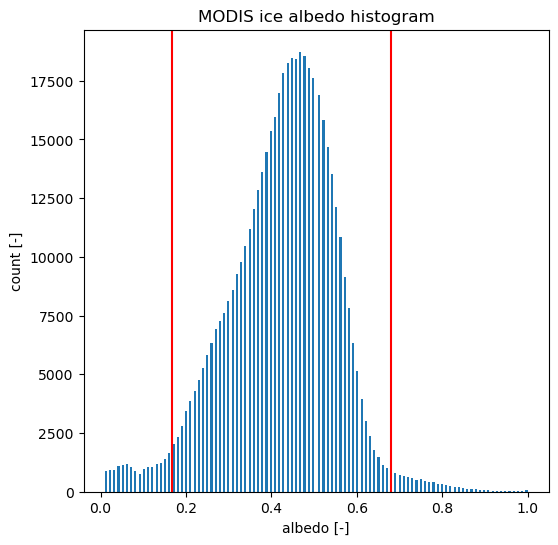

In [12]:
plt.figure(figsize=(6,6))
plt.hist(np.ravel(y), bins=200)
plt.axvline(mean + 2 * std, color='red')
plt.axvline(mean - 2 * std, color='red')
plt.xlabel('albedo [-]')
plt.ylabel('count [-]')
plt.title('MODIS ice albedo histogram')

# Only run if looking at difference between observed and modeled albedo

In [141]:
# y = y - ds.AL2.values[jun1:aug31+1,0,:n_lat,:n_lon]

# Convert floats into integers

In [142]:
# y = y * 100

# y_new = np.zeros((y.shape[0], y.shape[1], y.shape[2]), dtype='int')
# for t in range(y.shape[0]):
#     for i in range(y.shape[1]):
#         for j in range(y.shape[2]):
#             if y[t,i,j] >= 0:
#                 y_new[t,i,j] = int(y[t,i,j])

# y = y_new

# Prepare data for training and testing

#### Standardize the data so all values are in the 0-range, plusminus a couple (2-5).

In [12]:
x_dum = np.zeros((x.shape[0], x.shape[1], x.shape[2], x.shape[3]))
for i in range(x.shape[3]):
    
    mean, std = np.nanmean(x[:,:,:,i]), np.nanstd(x[:,:,:,i])
        
    x_dum[:,:,:,i]   = (x[:,:,:,i] - mean)/std
    
    if i == 16:
        AL2_mean, AL2_std = np.nanmean(x[:,:,:,i]), np.nanstd(x[:,:,:,i])

x = x_dum

#### Create mask of valid albedo pixels and only use pixels that have a realistic albedo value (> 0.1)

In [13]:
y_masknan = np.where((y > y_meanminus2sig) & (y < y_meanplus2sig), 1, np.nan)

y_mask = y * y_masknan
x_mask = np.zeros((numberdaystot,x.shape[1],x.shape[2],x.shape[3]))
for i in range(x.shape[3]):
    x_mask[:,:,:,i] = x[:,:,:,i] * y_masknan[:,:,:]

In [14]:
nonnans_2000_2015 = int(np.nansum(y_masknan[:92*16,:,:]))
nonnans_2016_2017 = int(np.nansum(y_masknan[92*16:92*17,:,:]) + np.nansum(y_masknan[92*17:92*18,:,:]))
nonnans_2018_2021 = int(np.nansum(y_masknan[92*18:,:,:]))

In [15]:
x_dum = x_mask[92*16:92*18,:,:,x.shape[3]-1]
x_dum = np.nan_to_num(x_dum, nan=0)
x_mask[92*16:92*18,:,:,x.shape[3]-1] = x_dum * y_masknan[92*16:92*18,:,:]

In [16]:
# get all non-nan values in y (where bareice==1) and put them in a 1D array
y_nonan = y_mask[~np.isnan(y_mask)]

# create zero matrix of same lenth as y_nonan, with space for all 20 features in x

# use only for lower half
# x_nonan = np.zeros((726996,x.shape[3]))
# use only for lower left quadrant
# x_nonan = np.zeros((505191,x.shape[3]))
x_nonan = np.zeros((494408,x.shape[3]))

# put values of x (where bareice==1) in x_nonan, for all MAR features (feat=(0,19))
for i in range(x.shape[3]-1):
# for i in range(x.shape[3]):
    x_mask_dum = x_mask[:,:,:,i]
    x_nonan[:,i] = x_mask_dum[~np.isnan(x_mask_dum)]


### put all non-nan algae values in x_nonan. there are only values for 2016 and 2017, so put nans in the other years but make sure it is the same length
# create dummy array of the algae values
x_mask_dum = x_mask[:,:,:,x.shape[3]-1]

# create nan-arrays to be put in 2000-2015 and 2018-2021
nans_2000_2015 = np.zeros((nonnans_2000_2015,1))
nans_2018_2021 = np.zeros((nonnans_2018_2021,1))
nans_2000_2015 = np.where(nans_2000_2015 == 0, np.nan, np.nan)
nans_2018_2021 = np.where(nans_2018_2021 == 0, np.nan, np.nan)

# put nans in x_nonan for 2000-2015
x_nonan[:nonnans_2000_2015,x.shape[3]-1] = nans_2000_2015[:,0]
# put non-nan algae values in x_nonan for 2016 and 2017
x_nonan[nonnans_2000_2015:nonnans_2000_2015+nonnans_2016_2017,x.shape[3]-1] = x_mask_dum[~np.isnan(x_mask_dum)]
# put nans in x_nonan for 2018-2021
x_nonan[nonnans_2000_2015+nonnans_2016_2017:,x.shape[3]-1] = nans_2018_2021[:,0]

x_nonan[:,x.shape[3]-1] = np.nan_to_num(x_nonan[:,x.shape[3]-1], nan=0)

# Split data into training (18/22) and testing (2/22) and validation (2/22)

In [17]:
X_train1, X_test, y_train1, y_test = train_test_split(x_nonan, y_nonan, test_size=(2/22), shuffle=False)

In [18]:
X_train1.shape, X_test.shape, y_train1.shape, y_test.shape

((449461, 27), (44947, 27), (449461,), (44947,))

In [19]:
X_train, X_val, y_train, y_val = train_test_split(X_train1, y_train1, test_size=(2/20), shuffle=False)

In [20]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((404514, 27), (44947, 27), (404514,), (44947,))

# Initialize and run XGB model

In [21]:
bst = XGBRegressor(n_estimators=1000,
                   max_depth=4,
                   max_leaves=0,
                   grow_policy='lossguide',
                   learning_rate=1,
                   verbosity=0,
                   booster='gbtree',
                   tree_method='exact',
                   reg_alpha=0.8,
                   reg_lambda=0.7,
                   objective='reg:squarederror',
                   eval_metric=mean_squared_error,
                   epochs=150,
                   early_stopping_rounds=10)

In [22]:
bst.fit(X_train, y_train, eval_set=[(X_val, y_val)])

[0]	validation_0-rmse:0.09505	validation_0-mean_squared_error:0.00903
[1]	validation_0-rmse:0.09130	validation_0-mean_squared_error:0.00834
[2]	validation_0-rmse:0.08979	validation_0-mean_squared_error:0.00806
[3]	validation_0-rmse:0.08836	validation_0-mean_squared_error:0.00781
[4]	validation_0-rmse:0.08760	validation_0-mean_squared_error:0.00768
[5]	validation_0-rmse:0.08713	validation_0-mean_squared_error:0.00759
[6]	validation_0-rmse:0.08676	validation_0-mean_squared_error:0.00753
[7]	validation_0-rmse:0.08595	validation_0-mean_squared_error:0.00739
[8]	validation_0-rmse:0.08542	validation_0-mean_squared_error:0.00730
[9]	validation_0-rmse:0.08521	validation_0-mean_squared_error:0.00726
[10]	validation_0-rmse:0.08459	validation_0-mean_squared_error:0.00715
[11]	validation_0-rmse:0.08439	validation_0-mean_squared_error:0.00712
[12]	validation_0-rmse:0.08437	validation_0-mean_squared_error:0.00712
[13]	validation_0-rmse:0.08380	validation_0-mean_squared_error:0.00702
[14]	validation_

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=10,
             enable_categorical=False, epochs=150,
             eval_metric=<function mean_squared_error at 0x1aa5493a0>,
             feature_types=None, gamma=None, gpu_id=None,
             grow_policy='lossguide', importance_type=None,
             interaction_constraints=None, learning_rate=1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=0,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, ...)

# Evaluate the model

In [23]:
y_test_pre = bst.predict(X_test)

In [24]:
AL2_test = ((X_test[:,16]) * AL2_std) + AL2_mean

#### Evaluation metrics for MODIS-XGB

In [25]:
R2_MODIS_RF = ma.corrcoef(y_test, y_test_pre)[1,0]**2
R2_MODIS_RF

0.47706338369804197

In [26]:
mean_squared_error(y_test, y_test_pre)

0.006457164298003357

In [27]:
# RMSE percentage
rmspe = np.sqrt(np.nanmean(np.square(((y_test - y_test_pre) / y_test)), axis=0))
rmspe

0.249919701302048

#### Evaluation metrics for MODIS-MAR

In [28]:
R2_MODIS_MAR = ma.corrcoef(y_test, AL2_test)[1,0]**2
R2_MODIS_MAR

0.055544040665414705

In [29]:
mean_squared_error(y_test, AL2_test)

0.031203916229028173

In [30]:
rmspe_MAR = np.sqrt(np.nanmean(np.square(((y_test - AL2_test) / y_test)), axis=0))
rmspe_MAR

0.6330278902648538

# Plots

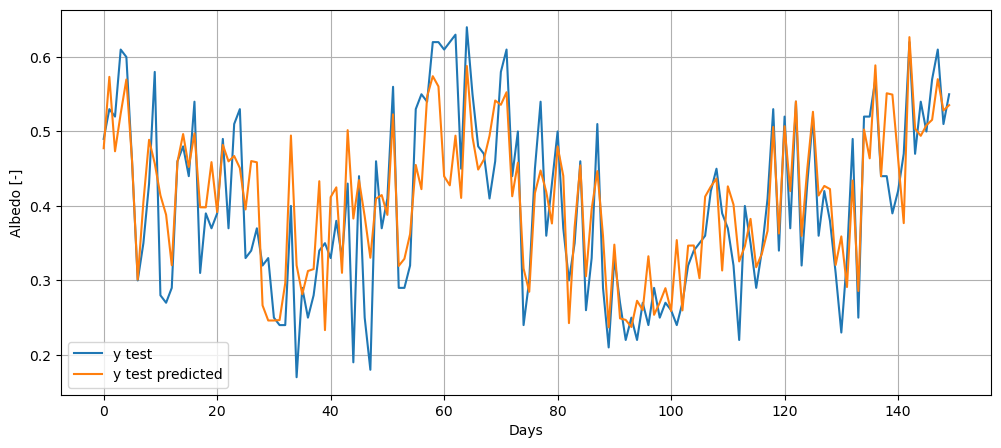

In [32]:
plt.figure(figsize=(12,5))
plt.plot(y_test[-150:], label='y test')
plt.plot(y_test_pre[-150:], label='y test predicted')
plt.xlabel('Days')
plt.ylabel('Albedo [-]')
plt.legend()
plt.grid()

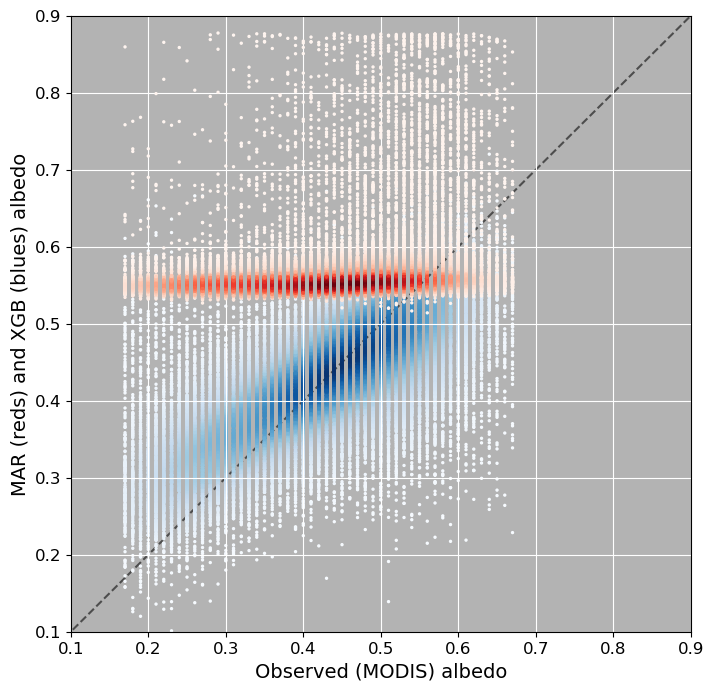

In [36]:
fig = plt.figure(figsize=(8,8))
ax = plt.gca()

# Calculate the point density
xy1 = np.vstack([y_test, y_test_pre])
z1 = gaussian_kde(xy1)(xy1)
xy2 = np.vstack([y_test, AL2_test])
z2 = gaussian_kde(xy2)(xy2)

plt.plot(np.arange(-1,100,1), np.arange(-1,100,1), color=[0.3, 0.3, 0.3], linestyle='--', linewidth=1.5, zorder=1)
plt.scatter(y_test, y_test_pre, c=z1, s=2, zorder=1, cmap='Blues')
plt.scatter(y_test, AL2_test, c=z2, s=2, zorder=2, cmap='Reds')

plt.xlabel('Observed (MODIS) albedo', fontsize=14)
plt.ylabel('MAR (reds) and XGB (blues) albedo', fontsize=14)
plt.grid(color='w', zorder=1)
ax.set_facecolor([0.7, 0.7, 0.7])
plt.tick_params(labelsize=12)
plt.xlim(0.1, 0.9);
plt.ylim(0.1, 0.9);

## Put y_test_pre back into map-form for plotting

In [31]:
# only use MODIS albedo values within 2-sigma
y_masknan_test = np.where((y > y_meanminus2sig) & (y < y_meanplus2sig), 1, np.nan)
y_mask_test = y * y_masknan_test

In [32]:
# get all non-nan values in y (where bareice==1) and put them in a 1D array
y_nonan_test = y_mask_test[~np.isnan(y_mask_test)]

In [33]:
indices = np.where(~np.isnan(y_mask_test) == 1)

In [34]:
# put y_test_pre values in a matrix of shape (201,207,115)
y_test_pre_vals = np.zeros((201,207,115))
for t in range(y_test_pre.shape[0]):
    y_test_pre_vals[indices[0][-44947+t]-1823, indices[1][-44947+t], indices[2][-44947+t]] = y_test_pre[t]

In [35]:
# for day 1823, not the entire day is predicted by XGB, only a couple of points. this is due to the 'arbitrary' cutoff of 2/22 I use in train_test_split
# therefore, start the comparison from day 1824 onwards
y_test_pre_plot = y_test_pre_vals[1:,:,:]

In [36]:
y_test_pre_plot = np.where(y_test_pre_plot == 0, np.nan, y_test_pre_plot)

In [37]:
n_lat_model = 207
n_lon_model = 115

/var/folders/8k/08rh6cnn3vl7qbdbxrryy07w0000gn/T/ipykernel_2983/83184807.py:10: RuntimeWarning: Mean of empty slice
  p1 = ax1.pcolor(LON[:n_lat_model,:n_lon_model], LAT[:n_lat_model,:n_lon_model], np.nanmean(y_mask_test[-200:,:,:], 0), cmap=cmap, zorder=2, vmin=0.1, vmax=0.8)
/var/folders/8k/08rh6cnn3vl7qbdbxrryy07w0000gn/T/ipykernel_2983/83184807.py:10: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  p1 = ax1.pcolor(LON[:n_lat_model,:n_lon_model], LAT[:n_lat_model,:n_lon_model], np.nanmean(y_mask_test[-200:,:,:], 0), cmap=cmap, zorder=2, vmin=0.1, vmax=0.8)
/var/folders/8k/08rh6cnn3vl7qbdbxrryy07w0000gn/T/ipykernel_2983/83184807.py:23: RuntimeWarning: Mean of empty slice
  p2 = ax2.pcolor(LON[:n_lat_model,:n_lon_model], LAT[:n_lat_model,:n_lon_model], np.nanmean(y_test_pre_plot, 0), cmap=cma

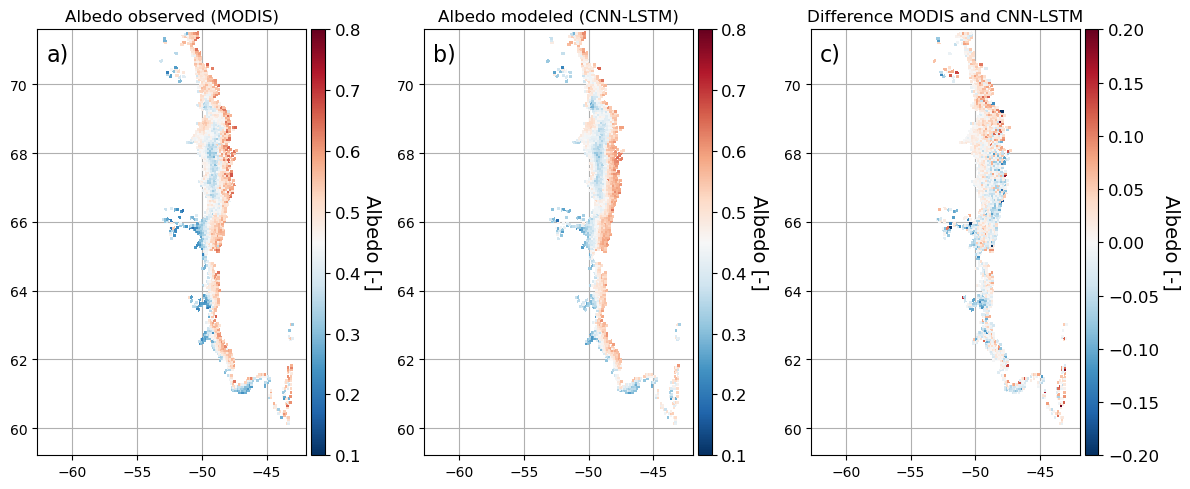

In [51]:
# plot y_mask_test because this has MODIS albedo values outside 2-sigma removed

tt = -102

fig = plt.figure(figsize=(12, 5))

cmap = 'RdBu_r'

ax1 = fig.add_subplot(131)
p1 = ax1.pcolor(LON[:n_lat_model,:n_lon_model], LAT[:n_lat_model,:n_lon_model], np.nanmean(y_mask_test[-200:,:,:], 0), cmap=cmap, zorder=2, vmin=0.1, vmax=0.8)
# p1 = ax1.pcolor(LON[:n_lat_model,:n_lon_model], LAT[:n_lat_model,:n_lon_model], y[tt,:,:], cmap=cmap, zorder=2, vmin=0.1, vmax=0.8)
ax1.text(-62, 70.7, 'a)', fontsize=16)
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar1 = fig.colorbar(p1, cax=cax, orientation='vertical')
cbar1.set_label('Albedo [-]', rotation=270, fontsize=14)
cbar1.ax.tick_params(labelsize=12)
cbar1.ax.get_yaxis().labelpad = 15
ax1.grid(zorder=1)
ax1.set_title('Albedo observed (MODIS)')

ax2 = fig.add_subplot(132)
p2 = ax2.pcolor(LON[:n_lat_model,:n_lon_model], LAT[:n_lat_model,:n_lon_model], np.nanmean(y_test_pre_plot, 0), cmap=cmap, zorder=2, vmin=0.1, vmax=0.8)
# p2 = ax2.pcolor(LON[:n_lat_model,:n_lon_model], LAT[:n_lat_model,:n_lon_model], y_test_pre_plot[tt,:,:], cmap=cmap, zorder=2, vmin=0.1, vmax=0.8)
ax2.text(-62, 70.7, 'b)', fontsize=16)
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar2 = fig.colorbar(p2, cax=cax, orientation='vertical')
cbar2.set_label('Albedo [-]', rotation=270, fontsize=14)
cbar2.ax.tick_params(labelsize=12)
cbar2.ax.get_yaxis().labelpad = 15
ax2.grid(zorder=1)
ax2.set_title('Albedo modeled (CNN-LSTM)')

ax3 = fig.add_subplot(133)
p3 = ax3.pcolor(LON[:n_lat_model,:n_lon_model], LAT[:n_lat_model,:n_lon_model], np.nanmean(y_mask_test[-200:,:,:], 0) - np.nanmean(y_test_pre_plot, 0), cmap=cmap, zorder=2, vmin=-0.2 ,vmax=0.2)
# p3 = ax3.pcolor(LON[:n_lat_model,:n_lon_model], LAT[:n_lat_model,:n_lon_model], y[tt,:,:] - y_test_pre_plot[tt,:,:], cmap=cmap, zorder=2, vmin=-0.4 ,vmax=0.4)
ax3.text(-62, 70.7, 'c)', fontsize=16)
divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar3 = fig.colorbar(p3, cax=cax, orientation='vertical')
cbar3.set_label('Albedo [-]', rotation=270, fontsize=14)
cbar3.ax.tick_params(labelsize=12)
cbar3.ax.get_yaxis().labelpad = 15
ax3.grid(zorder=1)
ax3.set_title('Difference MODIS and CNN-LSTM')

plt.tight_layout()

## Feature importance

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

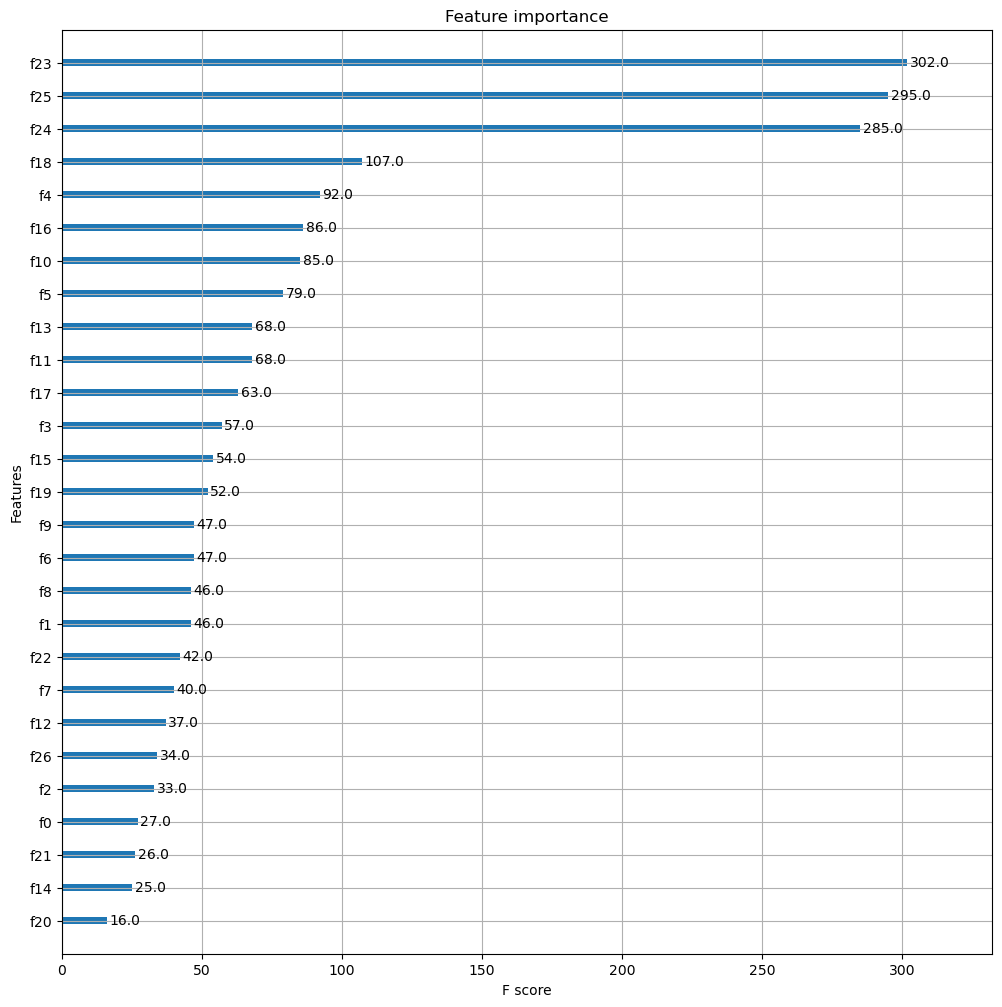

In [57]:
xgb.plot_importance(bst)

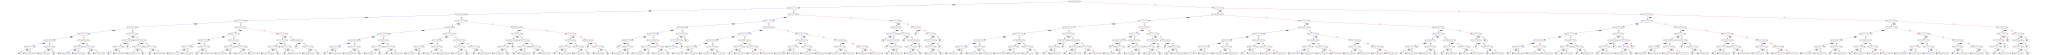

In [562]:
xgb.to_graphviz(bst, num_trees=bst.best_iteration)

# SHAP

In [576]:
explainer = shap.Explainer(bst.predict, X_train)
shap_values = explainer(X_test)

Permutation explainer: 24945it [1:29:41,  4.63it/s]                           


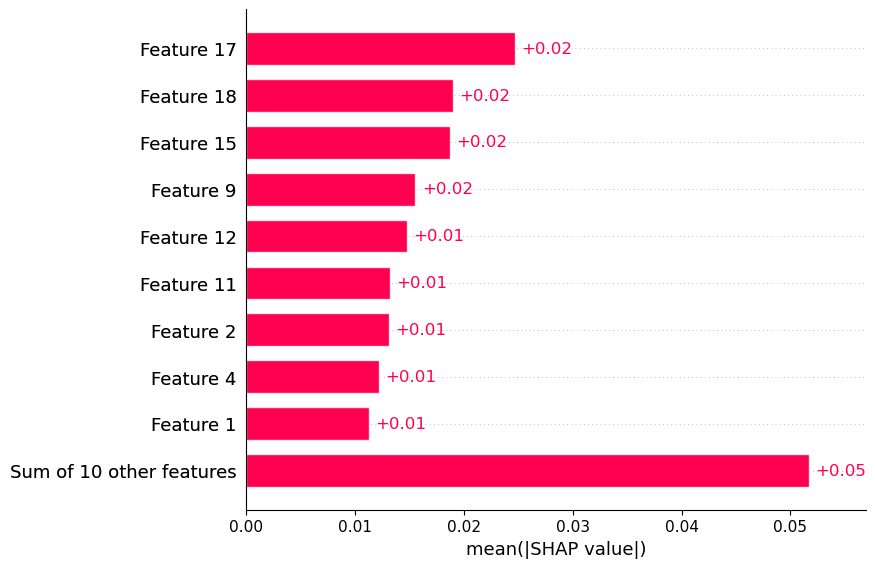

In [99]:
shap.plots.bar(shap_values)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


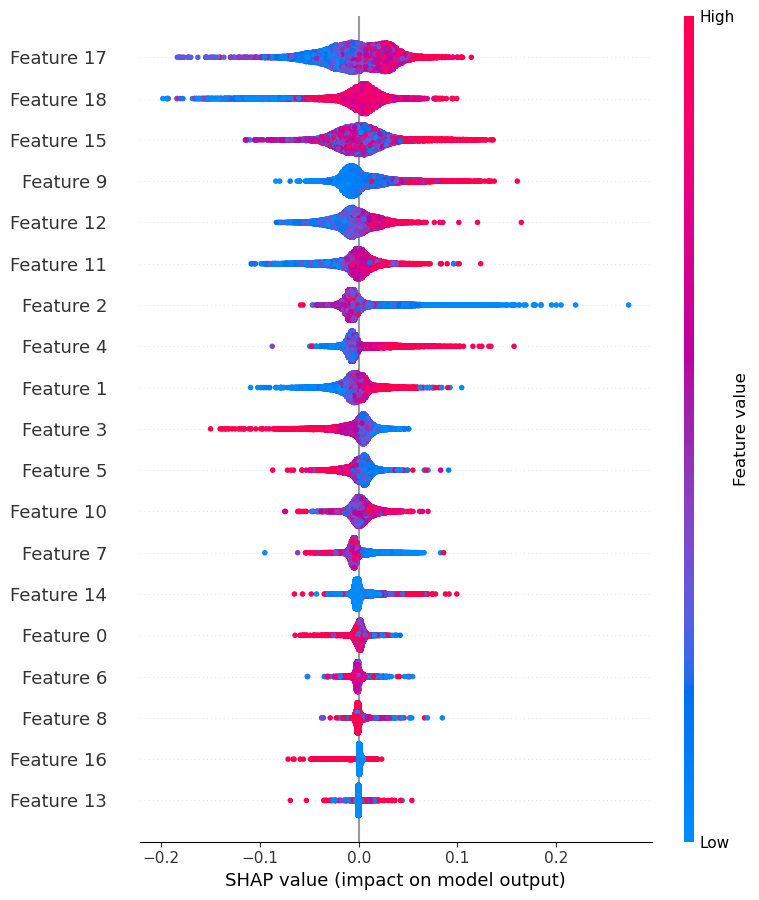

In [100]:
shap.summary_plot(shap_values)

In [ ]:
shap.plots.waterfall(shap_values)

In [ ]:
shap.plots.heatmap(shap_values[:1000])

# Equation Discovery

In [42]:
model = PySRRegressor(
    model_selection="best",
    unary_operators=["sin", "cos", "square", "cube", "exp", "abs", "log", "log10", "log2", "sqrt", "tan", "sinh", "cosh", "tanh",
                     "atan"],
    binary_operators=["+", "-", "/", "*"],
    maxdepth=5,
    maxsize=15,
    niterations=200,
    select_k_features=5,
    timeout_in_seconds=3600/10
)

In [43]:
dum = list(set(np.arange(0,y_nonan.shape[0])))
dum_rand = random.sample(dum, k=10000)

In [44]:
# from tqdm import tqdm

# for i in tqdm(range(100)):
#   model.fit(x_nonan[dum_rand,:], y_nonan[dum_rand])

In [ ]:
model.fit(x_nonan[dum_rand,:], y_nonan[dum_rand])

/Users/raf/mambaforge/envs/keras/lib/python3.9/site-packages/pysr/sr.py:1346: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Using features ['x1' 'x2' 'x5' 'x19' 'x23']


In [ ]:
print(model)

In [50]:
model.sympy()

-0.034944892*x1 + 0.034944892*x18 + 1.04397979561509/log(10)

In [56]:
y_predicted = model.predict(x_nonan)

/Users/raf/mambaforge/envs/keras/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PySRRegressor was fitted with feature names
  warnings.warn(


(array([3.0000e+00, 3.0000e+00, 3.0000e+00, 6.0000e+00, 7.0000e+00,
        9.0000e+00, 2.2000e+01, 8.2000e+01, 7.0800e+02, 6.6890e+03,
        2.9829e+04, 6.0504e+04, 8.8652e+04, 9.2669e+04, 7.8911e+04,
        3.8057e+04, 8.5470e+03, 1.2568e+04, 1.2793e+04, 1.1603e+04,
        9.1060e+03, 4.4790e+03, 1.8680e+03, 1.7520e+03, 1.5290e+03,
        1.4100e+03, 1.2210e+03, 1.0960e+03, 9.8600e+02, 9.4600e+02,
        8.9400e+02, 9.0100e+02, 9.3800e+02, 1.0750e+03, 1.1870e+03,
        1.4910e+03, 1.9160e+03, 1.7480e+03, 1.3530e+03, 1.1460e+03,
        1.3100e+03, 1.0870e+03, 9.3000e+02, 9.1200e+02, 9.3300e+02,
        8.4900e+02, 8.6500e+02, 7.5800e+02, 7.0000e+02, 6.5900e+02,
        6.3500e+02, 7.5300e+02, 1.0360e+03, 7.4800e+02, 4.7800e+02,
        5.9400e+02, 6.3600e+02, 7.2600e+02, 7.3900e+02, 3.5300e+02]),
 array([0.37552348, 0.37888706, 0.38225064, 0.38561422, 0.38897779,
        0.39234137, 0.39570495, 0.39906853, 0.40243211, 0.40579568,
        0.40915926, 0.41252284, 0.41588642, 0.

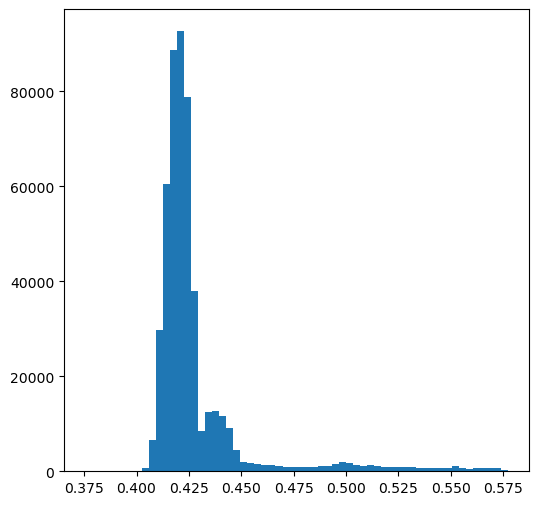

In [57]:
plt.figure(figsize=(6,6))
plt.hist(y_predicted, bins=60)

# Test equation

In [58]:
albedo = np.sqrt(0.27677915 * np.sqrt(X_test[:,16]))

### Calculate R^2 and MSE

In [59]:
R2_MODIS_eq = ma.corrcoef(y_test, albedo)[1,0]**2
R2_MODIS_eq

0.06702844464720399

In [60]:
mean_squared_error(y_test, albedo)

0.011471680121065947

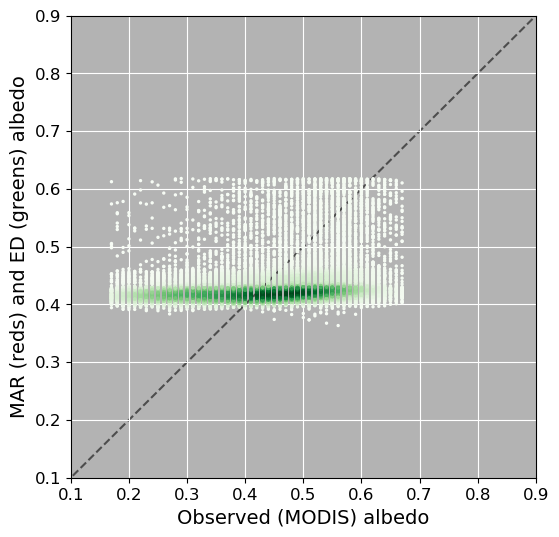

In [56]:
fig = plt.figure(figsize=(6,6))
ax = plt.gca()

# Calculate the point density
# xy1 = np.vstack([y_test, y_test_pre])
# z1 = gaussian_kde(xy1)(xy1)
xy2 = np.vstack([y_test, albedo])
z2 = gaussian_kde(xy2)(xy2)

plt.plot(np.arange(-1,100,1), np.arange(-1,100,1), color=[0.3, 0.3, 0.3], linestyle='--', linewidth=1.5, zorder=1)
# plt.scatter(y_test, y_test_pre, c=z1, s=2, zorder=1, cmap='Blues')
plt.scatter(y_test, albedo, c=z2, s=2, zorder=2, cmap='Greens')

plt.xlabel('Observed (MODIS) albedo', fontsize=14)
plt.ylabel('MAR (reds) and ED (greens) albedo', fontsize=14)
plt.grid(color='w', zorder=1)
ax.set_facecolor([0.7, 0.7, 0.7])
plt.tick_params(labelsize=12)
plt.xlim(0.1, 0.9);
plt.ylim(0.1, 0.9);